### Copyright 2020.#### 
**Author: H. Ngomseu Fotsing**

**Email: 217092052@student.uj.ac.za**

# Museum Artwork Image styles  Classification using CNN, VGG19 and SVM

In this notebook we will build on the model to classify 5 basic artwork styles(drawings, engraving, iconography, painting, sculpture) and improve accuracy by employing data augmentation

The Step in building are as follows:

1. Setting up libraries
2. Data collection and preprocessing.
3. Image classificaiton.
4. Loss and accuracy evaluation over the testing and training sets.

In [2]:
#importig the tensorflow library for data classification
import tensorflow as tf

## 1. Setting up Libraries
Importing necessary libraries for computing the data

In [3]:
#Importing libraries for data cleaning, segmentation and model classification
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator



import keras
from keras import regularizers, optimizers
from keras.applications import VGG16, VGG19
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import array_to_img, img_to_array
from keras.preprocessing.image import load_img
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

import cv2
from IPython.display import Image, display
import pickle
import random
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt #For displaying the performance of the model

In [4]:
#installing the pyDrive library to access files from drive acount
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [5]:
#authenticating the drive account
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
#loading the zip dataset file from the drive
fid = drive.ListFile({'q':"title='Artwork_dataset.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('Artwork_dataset.zip')

In [7]:
f.keys()

dict_keys(['id', 'kind', 'etag', 'selfLink', 'webContentLink', 'alternateLink', 'embedLink', 'iconLink', 'title', 'mimeType', 'labels', 'copyRequiresWriterPermission', 'createdDate', 'modifiedDate', 'modifiedByMeDate', 'lastViewedByMeDate', 'markedViewedByMeDate', 'version', 'parents', 'downloadUrl', 'userPermission', 'originalFilename', 'fileExtension', 'md5Checksum', 'fileSize', 'quotaBytesUsed', 'ownerNames', 'owners', 'lastModifyingUserName', 'lastModifyingUser', 'capabilities', 'editable', 'copyable', 'writersCanShare', 'shared', 'explicitlyTrashed', 'appDataContents', 'headRevisionId', 'spaces'])

## 2. Data Extraction
Here we extract the data from img_dsease ip file in our google drive storage


In [8]:
#Extracting the images files(Unzipping)
!unzip Artwork_dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset_updated/training_set/painting/0271.jpg  
  inflating: dataset_updated/training_set/painting/0272.jpg  
  inflating: dataset_updated/training_set/painting/0273.jpg  
  inflating: dataset_updated/training_set/painting/0274.jpg  
  inflating: dataset_updated/training_set/painting/0276.jpg  
  inflating: dataset_updated/training_set/painting/0277.jpg  
  inflating: dataset_updated/training_set/painting/0278.jpg  
  inflating: dataset_updated/training_set/painting/0279.jpg  
  inflating: dataset_updated/training_set/painting/0280.jpg  
  inflating: dataset_updated/training_set/painting/0281.jpg  
  inflating: dataset_updated/training_set/painting/0282.jpg  
  inflating: dataset_updated/training_set/painting/0283.jpg  
  inflating: dataset_updated/training_set/painting/0284.jpg  
  inflating: dataset_updated/training_set/painting/0285.jpg  
  inflating: dataset_updated/training_set/painting/0286.jpg  
  inflating: datase

In [9]:
PATH = 'dataset_updated'

In [10]:
os.listdir(PATH)

['validation_set', 'training_set']

In [11]:
#settingup the path of the traning and testing dataset
train_dir = os.path.join(PATH, 'training_set')
validation_dir = os.path.join(PATH, 'validation_set')

In [12]:

def filterbadFile(folder_path):
  extensions = []
  for fldr in os.listdir(folder_path):
      sub_folder_path = os.path.join(folder_path, fldr)
      for filee in os.listdir(sub_folder_path):
          file_path = os.path.join(sub_folder_path, filee)
          print('** Path: {}  **'.format(file_path), end="\r", flush=True)
          im = Image.open(file_path)
          rgb_im = im.convert('RGB')
          if filee.split('.')[1] not in extensions:
              extensions.append(filee.split('.')[1])
  return extensions

In [13]:
train_drawings_dir = os.path.join(train_dir, 'drawings')  # directory with our training drawings pictures
train_engraving_dir = os.path.join(train_dir, 'engraving')  # directory with our training engraving pictures
train_iconography_dir = os.path.join(train_dir, 'iconography')  # directory with our training iconography pictures
train_painting_dir = os.path.join(train_dir, 'painting')  # directory with our training painting pictures
train_sculpture_dir = os.path.join(train_dir, 'sculpture')  # directory with our training painting pictures

valid_drawings_dir = os.path.join(validation_dir, 'drawings')  # directory with our valid drawings pictures
valid_engraving_dir = os.path.join(validation_dir, 'engraving')  # directory with our validation engraving pictures
valid_iconography_dir = os.path.join(validation_dir, 'iconography')  # directory with our validation iconography pictures
valid_painting_dir = os.path.join(validation_dir, 'painting')  # directory with our validation_ painting pictures
valid_sculpture_dir = os.path.join(validation_dir, 'sculpture')  # directory with our validation painting pictures

In [14]:
#validating the dataset by evaluating the number of images
#Training set
num_drawings_tr = len(os.listdir(train_drawings_dir))
num_engraving_tr = len(os.listdir(train_engraving_dir))
num_iconography_tr = len(os.listdir(train_iconography_dir))
num_painting_tr = len(os.listdir(train_painting_dir))
num_sculpture_tr = len(os.listdir(train_sculpture_dir))

#Testing set
num_drawings_val = len(os.listdir(valid_drawings_dir))
num_engraving_val = len(os.listdir(valid_engraving_dir))
num_iconography_val = len(os.listdir(valid_iconography_dir))
num_painting_val = len(os.listdir(valid_painting_dir))
num_sculpture_val = len(os.listdir(valid_sculpture_dir))

#Evaluating total for testing and training set
total_train = num_drawings_tr + num_engraving_tr + num_iconography_tr + num_painting_tr + num_sculpture_tr
total_val = num_drawings_val + num_engraving_val + num_iconography_val + num_painting_val + num_sculpture_val

In [15]:
#Displaying result
print('total training num_drawings_tr images:', num_drawings_tr)
print('total training num_engraving_tr images:', num_engraving_tr)
print('total training num_iconography_tr images:', num_iconography_tr)
print('total training num_painting_tr images:', num_painting_tr)
print('total training num_sculpture_tr images:', num_sculpture_tr)
print("--")

print('total validation num_drawings_tr images:', num_drawings_val)
print('total validation num_engraving_tr images:', num_engraving_val)
print('total validation num_iconography_tr images:', num_iconography_val)
print('total validation num_painting_tr images:', num_painting_val)
print('total validation num_sculpture_tr images:', num_sculpture_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training num_drawings_tr images: 1126
total training num_engraving_tr images: 782
total training num_iconography_tr images: 2132
total training num_painting_tr images: 2261
total training num_sculpture_tr images: 1884
--
total validation num_drawings_tr images: 139
total validation num_engraving_tr images: 110
total validation num_iconography_tr images: 304
total validation num_painting_tr images: 316
total validation num_sculpture_tr images: 237
--
Total training images: 8185
Total validation images: 1106


###Data preprocessing
Rescaling data and storing in binary format for computation

In [16]:
#Initialising the model dimensions
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [17]:
# Normalize pixel values to be between 0 and 1
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [18]:
#Generating the training data from directory and formating it
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')


Found 8185 images belonging to 5 classes.


In [19]:
print(train_data_gen)

In [20]:
#generating the testing dataset from testing directory
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 1106 images belonging to 5 classes.


In [21]:
#Storing the training images and it labels
sample_training_images, train_labels = next(train_data_gen)

## 3. Image Classification
We segment and label the training data that will be used for evaluation and testing

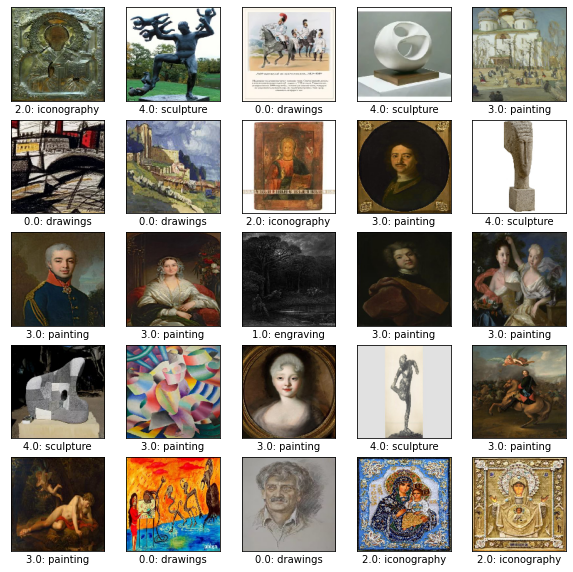

In [22]:
#Displaying a sample output for 25 images with labels from the dataset
class_names = ['drawings', 'engraving', 'iconography', 'painting', 'sculpture']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sample_training_images[i], cmap=plt.cm.binary)
    #plt.xlabel(str(train_labels[i]) + ': applescab')

    if(train_labels[i]==0.0):
      plt.xlabel(str(train_labels[i]) + ': drawings')
    elif(train_labels[i]==1.0):
      plt.xlabel(str(train_labels[i]) + ': engraving')
    elif(train_labels[i]==2.0):
      plt.xlabel(str(train_labels[i]) + ': iconography')
    elif(train_labels[i]==3.0):
      plt.xlabel(str(train_labels[i]) + ': painting')
    elif(train_labels[i]==4.0):
      plt.xlabel(str(train_labels[i]) + ': sculpture')
plt.show()

In [23]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('on')
    plt.tight_layout()
    plt.show()

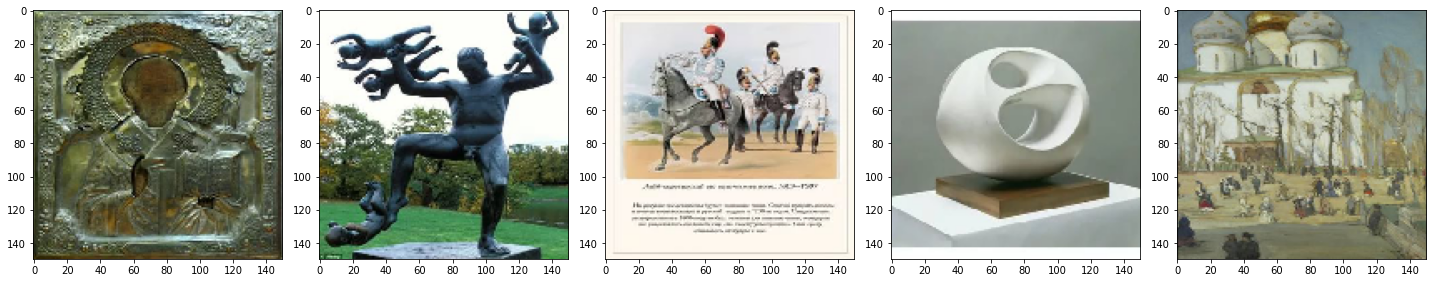

In [24]:
#Image segmentation
plotImages(sample_training_images[:5])

In [32]:
#setting up the model parameter with 3 convolutional layer and 3 denses
model = Sequential([
    Conv2D(32, (3, 3), input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(5, activation='softmax')
])

In [33]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [34]:
#generating the model
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/15
21/63 [=========>....................] - ETA: 18s - loss: 1.4938 - accuracy: 0.3954

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


63/63 [==============================] - 33s 526ms/step - loss: 1.3872 - accuracy: 0.5115 - val_loss: 1.2839 - val_accuracy: 0.6230
Epoch 2/15
63/63 [==============================] - 33s 520ms/step - loss: 1.2794 - accuracy: 0.6224 - val_loss: 1.2047 - val_accuracy: 0.7012
Epoch 3/15
63/63 [==============================] - 33s 524ms/step - loss: 1.2284 - accuracy: 0.6721 - val_loss: 1.2097 - val_accuracy: 0.6973
Epoch 4/15
63/63 [==============================] - 33s 521ms/step - loss: 1.2060 - accuracy: 0.6928 - val_loss: 1.1660 - val_accuracy: 0.7285
Epoch 5/15
63/63 [==============================] - 33s 520ms/step - loss: 1.1634 - accuracy: 0.7386 - val_loss: 1.1380 - val_accuracy: 0.7578
Epoch 6/15
63/63 [==============================] - 33s 521ms/step - loss: 1.1356 - accuracy: 0.7682 - val_loss: 1.1262 - val_accuracy: 0.7754
Epoch 7/15
63/63 [==============================] - 33s 520ms/step - loss: 1.1363 - accuracy: 0.7672 - val_loss: 1.1428 - val_accuracy: 0.7578
Epoch 8/15

## 4. Evaluating Loss and accuracy of training and Validation sets
Visual display of the performance, accuracy and loss using graphs 

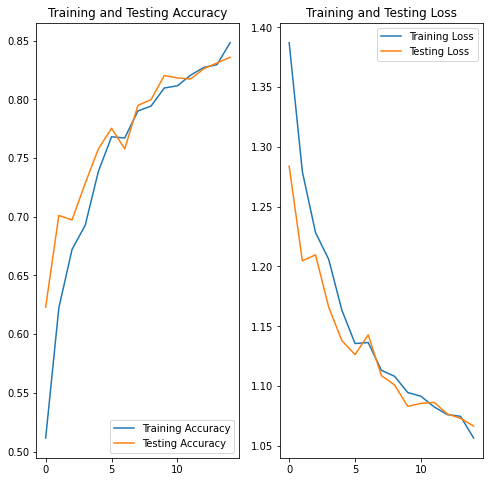

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

In [39]:
import matplotlib.pyplot as plt
from google.colab import files

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Testing Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Testing Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Testing Loss')
plt.legend(loc='upper right')
plt.title('Training and Testing Loss')
plt.show()
plt.savefig('samplefigure1.png')
files.download('samplefigure1.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

4/4 - 0s - loss: 1.0656 - accuracy: 0.8281


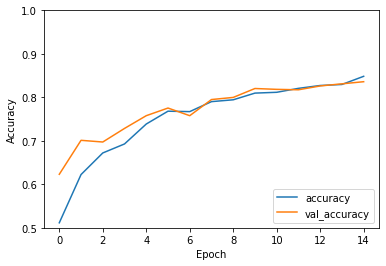

In [40]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.savefig('samplefigure.png')
files.download('samplefigure.png')

test_loss, test_acc = model.evaluate(sample_training_images,  train_labels, verbose=2)

In [37]:
print('Testing Accuracy: ' + str(test_acc))

Testing Accuracy: 0.828125


Evaluating dataset using VGG19 network

In [42]:
# Load the VGG19 network
vgg_model = VGG19(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
vgg_model.summary()

80142336/80134624 [==============================] - 4s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [43]:
model = Sequential([
    vgg_model,
    Flatten(),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')
])

vgg_model.trainable = False

# Check what layers are trainable
for layer in model.layers:
    print(layer.name, layer.trainable)
    
#model.summary()

vgg19 False
flatten_3 True
dense_9 True
dense_10 True


In [44]:
# Compilation
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# Fitting the Model
train_result = model.fit_generator(
            train_data_gen,
            steps_per_epoch=total_train // batch_size,
            epochs=epochs,
            validation_data=val_data_gen,
            validation_steps=total_val // batch_size
            )

Epoch 1/15
53/63 [========================>.....] - ETA: 6s - loss: 1.2167 - accuracy: 0.6860

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


63/63 [==============================] - 48s 761ms/step - loss: 1.2070 - accuracy: 0.6954 - val_loss: 1.1713 - val_accuracy: 0.7256
Epoch 2/15
63/63 [==============================] - 43s 677ms/step - loss: 1.1609 - accuracy: 0.7410 - val_loss: 1.1529 - val_accuracy: 0.7480
Epoch 3/15
63/63 [==============================] - 42s 673ms/step - loss: 1.1518 - accuracy: 0.7497 - val_loss: 1.1412 - val_accuracy: 0.7637
Epoch 4/15
63/63 [==============================] - 42s 674ms/step - loss: 1.1483 - accuracy: 0.7535 - val_loss: 1.1389 - val_accuracy: 0.7666
Epoch 5/15
63/63 [==============================] - 42s 673ms/step - loss: 1.1152 - accuracy: 0.7894 - val_loss: 1.0855 - val_accuracy: 0.8184
Epoch 6/15
63/63 [==============================] - 42s 674ms/step - loss: 1.0594 - accuracy: 0.8475 - val_loss: 1.0727 - val_accuracy: 0.8311
Epoch 7/15
63/63 [==============================] - 43s 679ms/step - loss: 1.0433 - accuracy: 0.8637 - val_loss: 1.0650 - val_accuracy: 0.8398
Epoch 8/15

In [45]:
model.save('VGG19_Feature.h5')

In [46]:
import seaborn as sns

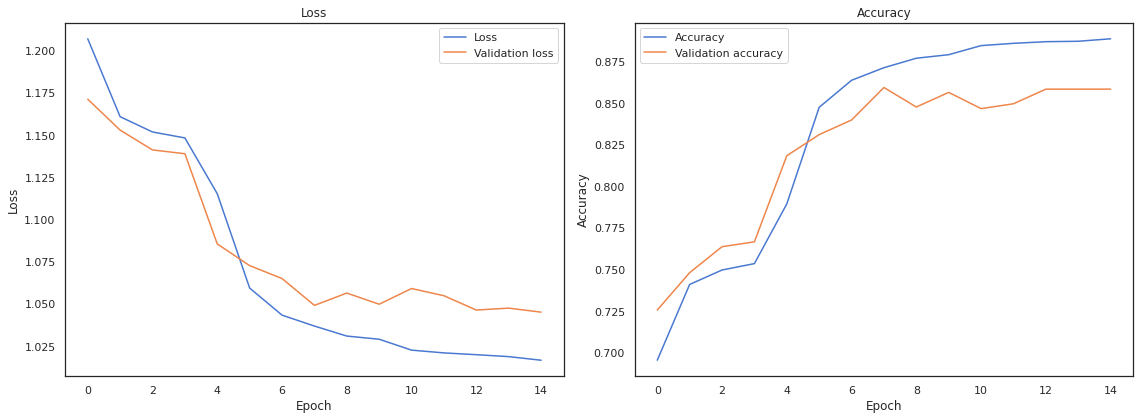

In [50]:
sns.set(style="white", palette="muted", color_codes=True)

fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

ax[0].plot(train_result.history['loss'], label="Loss")
ax[0].plot(train_result.history['val_loss'], label="Validation loss")
ax[0].set_title('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(train_result.history['accuracy'], label="Accuracy")
ax[1].plot(train_result.history['val_accuracy'], label="Validation accuracy")
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
plt.tight_layout()

plt.show();

Pipeline 2: Classificaiton using SVM

Visual display of the performance, accuracy and loss using graphs 

In [51]:
dir = train_dir
categories = ['drawings', 'engraving', 'iconography', 'painting', 'sculpture']
data = []

In [52]:
for category in categories:
  path = os.path.join(dir, category)
  label = categories.index(category)
  for img in os.listdir(path):
    imgpath = os.path.join(path,img)
    paint_img = cv2.imread(imgpath, 0)
    #display(Image(imgpath, width=300, height=200))
    try:
      paint_img = cv2.resize(paint_img, (50,50))
      image = np.array(paint_img).flatten()
      data.append([image, label])
    except Exception as e:
      pass

In [54]:
print(len(data))

pick_in = open('data1.pickle', 'wb')
pickle.dump(data, pick_in)
pick_in.close()

8185


In [55]:
pick_in = open('data1.pickle', 'rb')
data = pickle.load(pick_in)
pick_in.close()

In [56]:
random.shuffle(data)
features = []
labels = []

for feature, label in data:
  features.append(feature)
  labels.append(label)


In [71]:
xtrain, xtest, ytrain, ytest = train_test_split(features, labels, test_size = 0.25)

model = SVC(C=1, kernel='linear', probability=True, gamma='auto')
probas_ = model.fit(xtrain, ytrain).predict_proba(xtest)

Accuracy:  0.6287249633610161
Prediction is :  sculpture


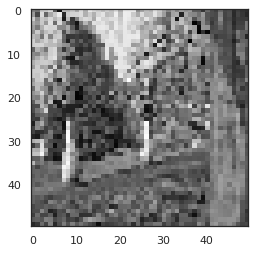

In [58]:
prediction = model.predict(xtest)
accuracy = model.score(xtest, ytest)

print('Accuracy: ', accuracy)
print('Prediction is : ', categories[prediction[0]])

mypaint = xtest[0].reshape(50,50)
#display(Image(mypaint, width=300, height=200))
plt.imshow(mypaint, cmap='gray')
plt.show()

In [59]:
pick = open('model.sav', 'wb')
pickle.dump(model, pick)
pick.close()

In [60]:
pick = open('model.sav', 'rb')
pickle.load(pick)
pick.close()

In [ ]:
# packages to import


import numpy as np
import pylab as pl
from sklearn import svm
from sklearn.utils import shuffle
import sklearn.metrics as metrics

from sklearn.metrics import roc_curve, auc
random_state = np.random.RandomState(0)

In [115]:
# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(ytest, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

ValueError: ignored

In [ ]:
# Plot ROC curve
pl.clf()
pl.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiverrating characteristic example')
pl.legend(loc="lower right")
pl.show()